In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.5.1
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



The three extensions below are optional, for more information, see
- `watermark`:  https://github.com/rasbt/watermark
- `pycodestyle_magic`: https://github.com/mattijn/pycodestyle_magic
- `nb_black`: https://github.com/dnanhkhoa/nb_black

In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293,E703,E402,E999 --max_line_length=100

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# MobileNetV3 (Large) Trained on CIFAR-10

MobileNetV3 [1] trained on CIFAR-10 [2].

### References

- [1] Searching for MobileNetV3, https://arxiv.org/abs/1905.02244.pdf
- [2] https://en.wikipedia.org/wiki/CIFAR-10

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings.

In [4]:
BATCH_SIZE = 256
NUM_EPOCHS = 150
LEARNING_RATE = 0.001
NUM_WORKERS = 4

<IPython.core.display.Javascript object>

- Note that using multiple workers can sometimes cause issues with too many open files in PyTorch for small datasets. If we have problems with the data loader later, try setting `NUM_WORKERS = 0` and reload the notebook.

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- In essence, `LightningModule` is a wrapper around a PyTorch module.
- We start with defining our neural network model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.
- Here, for the PyTorch model, we are using an implementation from the Torchvision hub:

In this case, since Torchvision already offers a nice and efficient PyTorch implementation of MobileNet-v2, let's load it from the Torchvision hub:

In [5]:
import torch


pytorch_model = torch.hub.load(
    'pytorch/vision:v0.11.0',
    'mobilenet_v3_large',
    pretrained=False)

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.11.0


<IPython.core.display.Javascript object>

In [6]:
# %load ../code_lightningmodule/lightningmodule_classifier_basic.py
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model
        if hasattr(model, "dropout_proba"):
            self.dropout_proba = model.dropout_proba

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=["model"])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)

        # Do another forward pass in .eval() mode to compute accuracy
        # while accountingfor Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()

        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log(
            "valid_acc",
            self.valid_acc,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


<IPython.core.display.Javascript object>

## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [7]:
# %load ../code_dataset/dataset_cifar10_check.py
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
    shuffle=True,
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=transforms.ToTensor()
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    shuffle=False,
)

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTraining label distribution:")
sorted(train_counter.items())

print("\nTest label distribution:")
sorted(test_counter.items())


Files already downloaded and verified

Training label distribution:

Test label distribution:


[(0, 1000),
 (1, 1000),
 (2, 1000),
 (3, 1000),
 (4, 1000),
 (5, 1000),
 (6, 1000),
 (7, 1000),
 (8, 1000),
 (9, 1000)]

<IPython.core.display.Javascript object>

### Performance baseline

- Especially for imbalanced datasets, it's pretty helpful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- we want our model to be better than that!

In [8]:
# %load ../code_dataset/performance_baseline.py
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 3
Accuracy when always predicting the majority class:
0.10 (10.00%)


<IPython.core.display.Javascript object>

## A quick visual check

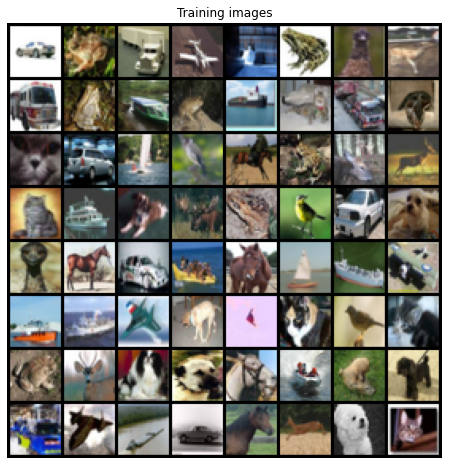

<IPython.core.display.Javascript object>

In [9]:
# %load ../code_dataset/plot_visual-check_basic.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the following subsection;
  3. create a LightningDataModule.
- Here, we will use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods, as we can see below:

In [10]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)

        self.train_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.RandomCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )

        self.test_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.CenterCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader

<IPython.core.display.Javascript object>

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the dataset loading -- if we run our code in a distributed setting, this will be called on each node / GPU. 
- Next, let's initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [11]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

<IPython.core.display.Javascript object>

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back to obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. However, here, we will keep things simple and use the `CSVLogger`:

In [12]:
# %load ../code_lightningmodule/logger_csv_acc_basic.py
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


lightning_model = LightningModel(pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="valid_acc"
    )  # save top 1 model
]
logger = CSVLogger(save_dir="logs/", name="my-model")

<IPython.core.display.Javascript object>

- Now it's time to train our model:

In [13]:
# %load ../code_lightningmodule/trainer_nb_basic.py
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=False,
    log_every_n_steps=10,
)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time) / 60
print(f"Training took {runtime:.2f} min in total.")


/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | MobileNetV3 | 5.5 M 
1 | train_acc | Accuracy    | 0     
2 | valid_acc | Accuracy    | 0     
3 | test_acc  | Accuracy    | 0     
------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
21.932    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 50.06 min in total.


<IPython.core.display.Javascript object>

## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (PS: you may want to check out [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) later on, which take care of it for us):

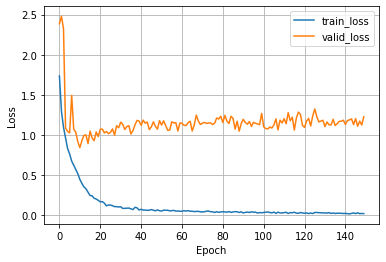

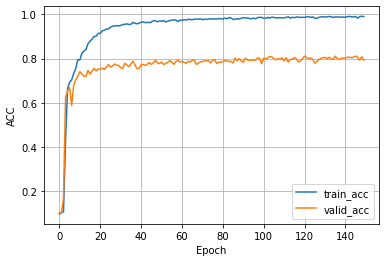

Restoring states from the checkpoint path at logs/my-model/version_6/checkpoints/epoch=145-step=25549.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_6/checkpoints/epoch=145-step=25549.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8066999912261963}
--------------------------------------------------------------------------------


[{'test_acc': 0.8066999912261963}]

<IPython.core.display.Javascript object>

In [14]:
# %load ../code_lightningmodule/logger_csv_plot_basic.py
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()


trainer.test(model=lightning_model, datamodule=data_module, ckpt_path="best")

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [15]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
Restoring states from the checkpoint path at logs/my-model/version_6/checkpoints/epoch=145-step=25549.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_6/checkpoints/epoch=145-step=25549.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8066999912261963}
--------------------------------------------------------------------------------


/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


[{'test_acc': 0.8066999912261963}]

<IPython.core.display.Javascript object>

## Predicting labels of new data

- We can use the `trainer.predict` method either on a new `DataLoader` (`trainer.predict(dataloaders=...)`) or `DataModule` (`trainer.predict(datamodule=...)`) to apply the model to new data.
- Alternatively, we can also manually load the best model from a checkpoint as shown below:

In [16]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_6/checkpoints/epoch=145-step=25549.ckpt


<IPython.core.display.Javascript object>

In [17]:
lightning_model = LightningModel.load_from_checkpoint(path, model=pytorch_model)
lightning_model.eval();

<IPython.core.display.Javascript object>

- For simplicity, we reused our existing `pytorch_model` above. However, we could also reinitialize the `pytorch_model`, and the `.load_from_checkpoint` method would load the corresponding model weights for us from the checkpoint file.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [18]:
# %load ../code_lightningmodule/datamodule_testloader.py
test_dataloader = data_module.test_dataloader()
acc = torchmetrics.Accuracy()

for batch in test_dataloader:
    features, true_labels = batch

    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]


tensor([7, 5, 8, 0, 8])

<IPython.core.display.Javascript object>

- As an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [19]:
test_acc = acc.compute()
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.8067 (80.67%)


<IPython.core.display.Javascript object>

## Inspecting Failure Cases

- In practice, it is often informative to look at failure cases like wrong predictions for particular training instances as it can give us some insights into the model behavior and dataset.
- Inspecting failure cases can sometimes reveal interesting patterns and even highlight dataset and labeling issues.

In [20]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

<IPython.core.display.Javascript object>

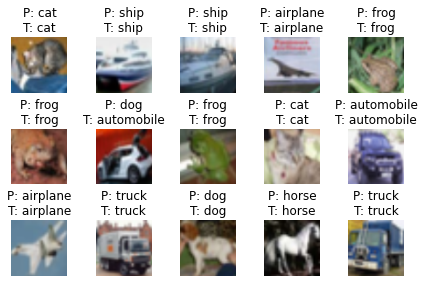

<IPython.core.display.Javascript object>

In [21]:
# %load ../code_lightningmodule/plot_failurecases_basic.py
# Append the folder that contains the
# helper_data.py, helper_plotting.py, and helper_evaluate.py
# files so we can import from them

import sys

sys.path.append("../../pytorch_ipynb")

from helper_plotting import show_examples


show_examples(
    model=lightning_model, data_loader=test_dataloader, class_dict=class_dict
)


- In addition to inspecting failure cases visually, it is also informative to look at which classes the model confuses the most via a confusion matrix:

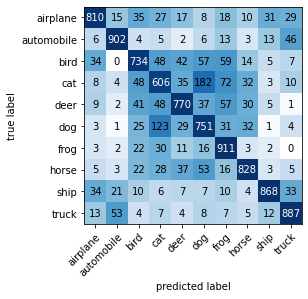

<IPython.core.display.Javascript object>

In [22]:
# %load ../code_lightningmodule/plot_confusion-matrix_basic.py
from torchmetrics import ConfusionMatrix
import matplotlib
from mlxtend.plotting import plot_confusion_matrix


cmat = ConfusionMatrix(num_classes=len(class_dict))

for x, y in test_dataloader:

    with torch.no_grad():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()  
    # normed colormaps highlight the off-diagonals 
    # for high-accuracy models better
)

plt.show()

In [24]:
%watermark --iversions

mlxtend          : 0.20.0.dev0
sys              : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
torchvision      : 0.11.2
matplotlib       : 3.3.4
torch            : 1.10.1
pytorch_lightning: 1.5.1
torchmetrics     : 0.6.2
pandas           : 1.4.1
numpy            : 1.22.0



<IPython.core.display.Javascript object>